In [17]:
import os
import math as m
import time
from codes_gendrops_py.genSingleDrop import *
from codes_gendrops_py.fit_circle_through_3_points import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.backends.backend_agg import FigureCanvasAgg
from pre_process_functions import *
from PIL import Image
import numpy as np


## Definite the pre processing functions

In [2]:
def gen_doplet_v4(sigma,volume0,rneedle=0.5):
    # when output=1 gSD return r_a,z_a
    r_a,z_a=genSingleDrop(sigma=sigma,volume0=volume0,rneedle=rneedle,output=1)
    wmax=2*max(abs(r_a))

    # use plt generate synthetic image and save as arrayd
    plt.fill_between(r_a,z_a,color='black')
    plt.fill_between(-r_a,z_a,color='black')
    plt.axis('equal')
    plt.axis('off')

    figure = plt.gcf().canvas
    ag = figure.switch_backends(FigureCanvasAgg)
    ag.draw()
    plt.close()
    A = np.asarray(ag.buffer_rgba())
    syn_array = np.rint(A[...,:3] @ [0.2126, 0.7152, 0.0722]).astype(np.uint8)
    

    return syn_array,wmax,rneedle

In [3]:
def crop_margin_array_v4(syn_array):#(DONE)
        
        (row,col)=syn_array.shape
        img=syn_array

        for i in range(row-1):
                if sum(img[i])!=255*col:
                        cut1=i
                        break               

        for i in range(row-1,0,-1):
                if sum(img[i])!=255*col:
                        cut2=i
                        break 

        _,img1,_=np.split(img,[cut1,cut2])  

        for i in range(col-1):
                if sum(img[:,i])!=255*row:
                        cut3=i
                        break

        for i in range(col-1,0,-1):
                if sum(img[:,i])!=255*row:
                        cut4=i
                        break

        _,cm_arr,_=np.split(img1,[cut3,cut4],axis=1)

        return cm_arr

In [4]:
def resize_syn_arr(syn_arr_cm,wmax,r_syn=1):
    syn_img = Image.fromarray(syn_arr_cm)
    w,h=syn_img.size
    r_syn=1
    w_n=wmax/(2*r_syn)*50
    scaling=w_n/w
    h_n=scaling*h
    new_syn=syn_img.resize((int(w_n),int(h_n)))
    syn_arr_rs=np.asarray(new_syn)

    return syn_arr_rs

In [5]:
def remove_needle_centering_v4(img_ori):#(Need Test)
    '''img_ori=Image.open(path_ori)'''
    w_ori,h_ori=img_ori.size

    scaling_ori=300/w_ori # reshape the origin image to width 300

    w_ori2=int(scaling_ori*w_ori)
    h_ori2=int(scaling_ori*h_ori)

    A=img2bw(ResizeImage(img_ori,w_ori2,h_ori2))

    left_edge=np.zeros(w_ori2)
    right_edge=np.zeros(w_ori2)
    for i in range(h_ori2):
        for j in range(w_ori2):
            if A[i,j-1]>=125 and A[i,j]<125:
                #print('Left position',i,j)
                left_edge[i]=j
            if A[i,j-1]<=125 and A[i,j]>125:
                #print('Right position',i,j)
                right_edge[i]=j

    needle=np.abs(left_edge-right_edge)

    end=0
    for j in range(needle.shape[0]-1):
        j=j+1
        if end == 0:
            if abs((needle[j]-needle[0])/needle[0])>0.05:
                stopline=j
                end=end+1
    #print(stopline)

    addpad=right_edge[stopline]-needle[stopline]/2-w_ori2/2

    img_WON=np.zeros((h_ori2-stopline,w_ori2))
    for i in range(h_ori2):
        if i>=stopline:
            img_WON[i-stopline,:]=A[i,:]
    
    h_won,w_won=img_WON.shape
    
    # centering
    if addpad>0:
        img_won=np.hstack( ( img_WON,np.ones((h_won,abs(int(addpad*4))))*255 ) )
    elif addpad<0:
        img_won=np.hstack( ( np.ones((h_won,abs(int(addpad*4))))*255,img_WON ) )
    else:
        img_won=img_WON

    return img_won,needle

In [6]:
def cost_v3(img_ori,img_syn,width=100,output=0):
    '''
    input:              
    x:                the origin point of synthetic image
    img_syn,img_ori:    the images that need to calculate the cost 
                        should be valued by 'Image.open(path)'
    K:                  the scaling of synthethic image
    output: 0 -->lost, 1-->C, else C,lost
    '''
    img_syn = Image.fromarray(img_syn)
    img_ori = Image.fromarray(img_ori)

    w_ori,h_ori=img_ori.size
    w_syn,h_syn=img_syn.size
    

    scaling_ori=width/w_ori # reshape the origin image to width
    w_ori2=int(scaling_ori*w_ori)
    h_ori2=int(scaling_ori*h_ori)
    scaling_syn=scaling_ori
    w_syn2=int(scaling_syn*w_syn)
    h_syn2=int(scaling_syn*h_syn)
    x=int(abs((w_syn2-w_ori2)/2))

    A=img2bw(ResizeImage(img_ori,w_ori2,h_ori2))
    one=np.ones((w_ori2-h_ori2,w_ori2))*255
    A=np.row_stack((A,one))


    B=img2bw(ResizeImage(img_syn,w_syn2,h_syn2))
    C=np.zeros((w_ori2,w_ori2))

    droplet=0
    for i in range(w_ori2):
        for j in range (h_ori2):
            if A[i,j]==255:
                droplet=droplet+1

    for i in range (w_ori2): # h
        for j in range(w_ori2): # w
            #print (h_ori2,w_ori2)
            #print(i,j)
            if j < x or j-x >= w_syn2 or i >= h_syn2 :
                 C[i,j]=A[i,j]
            else:
                if  A[i,j]==B[i,j-x]: # B[i-y,j-x]
                    C[i,j]=255
                else:
                    C[i,j]=0
    
    # pixel that same(T) different(F) and drop area
    t=0; f=0; 
    #drop_ori=0; drop_gen=0 
    for i in range (w_ori2):
        for j in range(h_ori2):
            if C[i,j]==0:
                f=f+1
            else:
                t=t+1
    #lost=f/max(w_ori2*h_ori2,w_syn2*h_syn2)
    
    lost=f/droplet
    accurancy=1-lost

    if output == 0:
        return lost
    elif output == 1:
        return C
    else:
        return C,lost

## Definite the obtimize funciton

In [7]:
def obtimize_v4(sv,path_ori=os.path.abspath('./images_experiment/220304_miliq_T17.7_S73.04.png'),output=0):
    '''need initialize xs and losts if output==0'''
    start = time.time()
    sigma=sv[0]
    v0=sv[1]

    # preprosessing the ori image
    ori,needle=remove_needle_centering_v4(Image.open(path_ori))
    pixel_needle=needle[0]

    # gen and post processing the syn image
    syn_arr,wmax,rneedle=gen_doplet_v4(sigma=sigma,volume0=v0,rneedle=0.5)

    #crop the margin of syn image
    syn_arr_cm=crop_margin_array_v4(syn_arr)
    syn=resize_syn_arr(syn_arr_cm,wmax,r_syn=1)

    end = time.time()
    print('Obtimize Program execution time: ',end - start)

    if output==0:
        lost=cost_v3(ori,syn,output=output)
        xs.append(sv)
        losts.append(lost)
        print(sv,lost)
        return lost
    elif output==1:
        C=cost_v3(ori,syn,output=output)
        return C
    else :
        C,lost=cost_v3(ori,syn,output=output)
        return C, lost

## Start the optimization

In [8]:
import scipy.optimize
# use scipy obtimaize the parameter
xs=[]
losts=[]
x0=np.asarray((75,11))
#sigma; v0; length_Ne,r_Ne; x,y; scaling_rate;
res=scipy.optimize.minimize(obtimize_v4,x0,method='nelder-mead',options={'maxiter':50})

Gen Image Program execution time:  2.97795033454895
Obtimize Program execution time:  3.3857085704803467
[75. 11.] 0.1492329149232915
Gen Image Program execution time:  3.034444570541382
Obtimize Program execution time:  3.404287576675415
[78.75 11.  ] 0.1589958158995816
Gen Image Program execution time:  2.674450159072876
Obtimize Program execution time:  3.0314629077911377
[75.   11.55] 0.12631998406056982
Gen Image Program execution time:  2.809702157974243
Obtimize Program execution time:  3.1648993492126465
[71.25 11.55] 0.12153815501095835
Gen Image Program execution time:  2.1935553550720215
Obtimize Program execution time:  2.5480563640594482
[67.5   11.825] 0.11137676828053397
Gen Image Program execution time:  2.1099934577941895
Obtimize Program execution time:  2.4661898612976074
[67.5   12.375] 0.08786610878661087
Gen Image Program execution time:  2.272503137588501
Obtimize Program execution time:  2.6290485858917236
[63.75   13.0625] 0.06535166367802352
Gen Image Program 

In [9]:
print(res)

 final_simplex: (array([[58.50418568, 13.40377846],
       [58.50421345, 13.40378647],
       [58.50425196, 13.4037803 ]]), array([0.03964933, 0.03964933, 0.03964933]))
           fun: 0.039649332536361825
       message: 'Optimization terminated successfully.'
          nfev: 84
           nit: 31
        status: 0
       success: True
             x: array([58.50418568, 13.40377846])


In [16]:
%matplotlib notebook
arxs=np.asarray(xs)
plt.plot(arxs[:,0],arxs[:,1])


<IPython.core.display.Javascript object>

AttributeError: 'list' object has no attribute 'show'

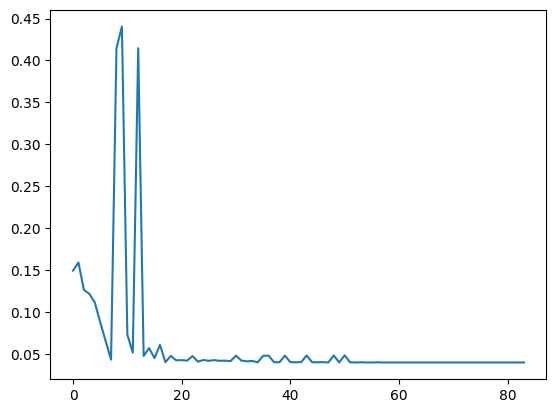

In [14]:
plt.plot(losts)


AttributeError: module 'matplotlib.pyplot' has no attribute 'get_camp'

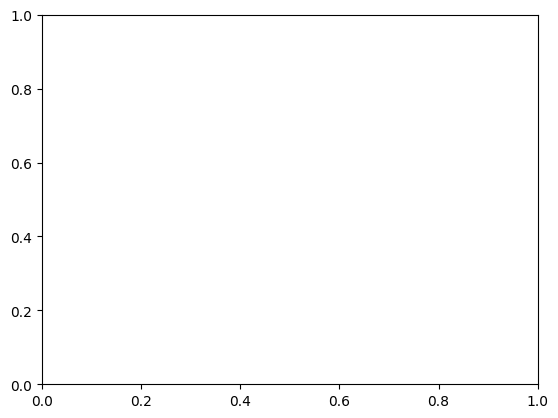

In [12]:
x=arxs[:,0]
y=arxs[:,1]

z=losts

fig,ax=plt.subplots()
cs=ax.contourf(x,y,z,cmap=plt.get_camp('Spectal'))

cbar=fig.colorbar(cs)
plt.show

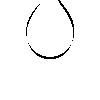

In [13]:
x=np.asarray((73,16))
C,lost=obtimize_v3(sv=x,output=2)
Image.fromarray(np.uint8(C))